### Configurable Variables
Variables that can be modified in this notebook
- `input_data` — path to the input folder containing the dataset
- `show_gene` — the gene to visualize in the spatial expression plot
- `supress_warnings` — boolean flag to enable/disable warning messages (`True`/`False`)
---
**Set following variables if you are running notebook interactively.**

In [1]:
input_path_default = "data/SN048_A121573_Rep1"
show_gene_default = "FAM41C"
suppress_warnings_default = False

# DATA OVERVIEW
## **Identification of spatially variable genes in spatial transcriptomics of colorectal cancer**

---

### Load variables from CMD

In [2]:
try:
    if suppress_warnings == "True":
        SUPPRESS_WARNINGS = True
    else:
        SUPPRESS_WARNINGS = False
except NameError:
    SUPPRESS_WARNINGS = suppress_warnings_default

try:
    GENE = show_gene
except NameError:
    GENE = show_gene_default


## Suppress Warnings (Optional)

* Suppress warnings for cleaner output.  
* Comment out the line below if warnings are desired for debugging.

In [3]:
# Suppress warnings for cleaner output
import warnings
import os

if SUPPRESS_WARNINGS:
    print("Ignoring warnings.")
    warnings.filterwarnings('ignore')

### Environment setup

1. Install the necessary packages using `pip` if they are not already installed:

In [4]:
!pip install scanpy squidpy --quiet
!pip install ipywidgets pandas --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


2. Import necessary libraries:

*   libraries for data-handling



In [5]:
import squidpy as sq
import pandas as pd
import scanpy as sc
import os
import sys

print("Using scanpy version:", sc.__version__, ", SquidPy version:", sq.__version__, ", Pandas version:", pd.__version__)

/Users/polakova/PycharmProjects/IV114_ST/.venv/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/polakova/PycharmProjects/IV114_ST/.venv/lib/python3.11/site-packages/squidpy/gr/_utils.py:23: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  CAN_USE_SPARSE_ARRAY = Version(anndata.__version__) >= Version("0.11.0rc1")


Using scanpy version: 1.11.5 , SquidPy version: 1.6.5 , Pandas version: 2.3.3


/Users/polakova/PycharmProjects/IV114_ST/.venv/lib/python3.11/site-packages/anndata/__init__.py:70: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/var/folders/n1/v7nxdxqs1qq7ck0bphkynr1c0000gp/T/ipykernel_59021/376527534.py:7: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print("Using scanpy version:", sc.__version__, ", SquidPy version:", sq.__version__, ", Pandas version:", pd.__version__)


* libraries for visualization:

In [6]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

3. load the dataset
  * **Option 1**: Import data directly from Google Drive (requires Google Colab).
  * **Option 2**: Load dataset path from CMD.



In [7]:
# OPTION 1
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# OPTION 2
DATA_PATH = None
try:
    DATA_PATH = input_data
except NameError:
    DATA_PATH = input_path_default

if DATA_PATH is None or not os.path.exists(DATA_PATH):
    print("ERROR: Datapath (", DATA_PATH ,") not found.")
    sys.exit()

print("Using input path:", DATA_PATH)

DATA_FOLDER_NAME = DATA_PATH.split("/")[-1].strip()

save_dir = "figures/show/qc/" + DATA_FOLDER_NAME
os.makedirs(save_dir, exist_ok=True)

Using input path: data/SN048_A121573_Rep1


## Data visualization
1. Loading Spatial Transcriptomics Data

In [9]:
# Load 10x Genomics Visium spatial transcriptomics data
# Creates AnnData object that contains counts, metadata, and spatial coordinates
adata = sc.read_visium(path=DATA_PATH)
# Verify the structure of the AnnData object
print(adata)

/var/folders/n1/v7nxdxqs1qq7ck0bphkynr1c0000gp/T/ipykernel_59021/918080676.py:3: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(path=DATA_PATH)


AnnData object with n_obs × n_vars = 2203 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


/Users/polakova/PycharmProjects/IV114_ST/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/polakova/PycharmProjects/IV114_ST/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
# Define path to the CSV file containing tissue positions
spatial_file_csv = os.path.join(DATA_PATH, "spatial", "tissue_positions_list.csv")
spatial_df = None
# Load spatial metadata if the file exists
if os.path.exists(spatial_file_csv):
    spatial_df = pd.read_csv(spatial_file_csv, header=None)
else:
    spatial_df = None
    print("No tissue_positions_list file found. Verify it is located at spatial/tissue_positions_list.csv.")
    sys.exit()

In [11]:
# - adata.obs: metadata about spots
# - adata.var: metadata about genes
print(adata.obs.columns)
print(adata.var.columns)

Index(['in_tissue', 'array_row', 'array_col'], dtype='object')
Index(['gene_ids', 'feature_types', 'genome'], dtype='object')


In [12]:
# Check the 'in_tissue' annotation
# This variable distinguishes tissue spots (1) from background (0)
# It's important for filtering and spatial plotting

if "in_tissue" in adata.obs.columns:
    print(adata.obs["in_tissue"].value_counts())
else:
    print("ERROR: 'in_tissue' not found — verify that tissue_positions_list.csv was imported correctly.")
    sys.exit()

# Basic check for duplicates and completeness
# Verify that barcode IDs are unique and that the number of spots matches metadata.

print("Number of duplicated barcodes:", adata.obs_names.duplicated().sum())
print("Spots in adata vs. rows in spatial_df:", len(adata.obs), len(spatial_df))

in_tissue
1    2203
Name: count, dtype: int64
Number of duplicated barcodes: 0
Spots in adata vs. rows in spatial_df: 2203 4992


In [13]:
# Alternative loading of expression matrix (if available as .h5 file)
adata_h5 = sc.read_10x_h5(DATA_PATH + "/filtered_feature_bc_matrix.h5")

# Check structure of the h5 file dataset
print("Check structure of the h5 file:")
print(adata_h5)

Check structure of the h5 file:
AnnData object with n_obs × n_vars = 2203 × 36601
    var: 'gene_ids', 'feature_types', 'genome'


/Users/polakova/PycharmProjects/IV114_ST/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/polakova/PycharmProjects/IV114_ST/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [14]:
# Display first 5 genes (rows from gene annotation table)
print(adata_h5.var.head())

                    gene_ids    feature_types  genome
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38
FAM138A      ENSG00000237613  Gene Expression  GRCh38
OR4F5        ENSG00000186092  Gene Expression  GRCh38
AL627309.1   ENSG00000238009  Gene Expression  GRCh38
AL627309.3   ENSG00000239945  Gene Expression  GRCh38


In [15]:
# Display first 5 barcodes (rows from spot metadata)
print(adata_h5.obs.head())

Empty DataFrame
Columns: []
Index: [AAACAAGTATCTCCCA-1, AAACACCAATAACTGC-1, AAACATTTCCCGGATT-1, AAACCCGAACGAAATC-1, AAACCGGGTAGGTACC-1]


In [16]:
# Show first 10 gene names to verify import
print(adata.var_names[:10])

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1'],
      dtype='object')


In [17]:
# Check if spatial coordinates exist and preview first few rows
if 'spatial' in adata.obsm:
    pass
    # print(adata.obsm['spatial'][:5])
else:
    print("ERROR: Spatial coordinates not found.")
    sys.exit()


In [18]:
# Display shape and dimensions of the AnnData object
print("Shape of AnnData:", adata.shape)
print("Number of spots (obs):", adata.n_obs)
print("Number of genes (var):", adata.n_vars)

Shape of AnnData: (2203, 36601)
Number of spots (obs): 2203
Number of genes (var): 36601


In [19]:
# Display shape and preview the first few rows of spatial metadata
print(spatial_df.shape)
print(spatial_df.head())

(4992, 6)
                    0  1  2  3    4    5
0  ACGCCTGACACGCGCT-1  0  0  0  151  214
1  TACCGATCCAACACTT-1  0  1  1  174  227
2  ATTAAAGCGGACGAGC-1  0  0  2  151  240
3  GATAAGGGACGATTAG-1  0  1  3  174  253
4  GTGCAAATCACCAATA-1  0  0  4  151  266


In [20]:
# Add spatial coordinates from CSV file to AnnData metadata

if spatial_df is not None:
    spatial_df.columns = [
        "barcode", "in_tissue", "array_row", "array_col",
        "pxl_row_in_fullres", "pxl_col_in_fullres"
    ]
    spatial_df.set_index("barcode", inplace=True)

    # Join spatial info with AnnData observations (obs table)
    adata.obs = adata.obs.join(
        spatial_df[["pxl_row_in_fullres", "pxl_col_in_fullres"]],
        how="left", rsuffix='_spatial'
    )

# Check updated metadata table
print(adata.obs.shape)
print("\nFirst 5 spots with metadata:")
print(adata.obs.head())

(2203, 5)

First 5 spots with metadata:
                    in_tissue  array_row  array_col  pxl_row_in_fullres  \
AAACAAGTATCTCCCA-1          1         50        102                1297   
AAACACCAATAACTGC-1          1         59         19                1502   
AAACATTTCCCGGATT-1          1         61         97                1548   
AAACCCGAACGAAATC-1          1         45        115                1182   
AAACCGGGTAGGTACC-1          1         42         28                1113   

                    pxl_col_in_fullres  
AAACAAGTATCTCCCA-1                1554  
AAACACCAATAACTGC-1                 462  
AAACATTTCCCGGATT-1                1488  
AAACCCGAACGAAATC-1                1725  
AAACCGGGTAGGTACC-1                 581  


In [21]:
# Show additional genes for quick reference
print(adata.var_names[:20])

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       'OR4F29', 'AC114498.1', 'OR4F16', 'AL669831.2', 'LINC01409', 'FAM87B',
       'LINC01128', 'LINC00115', 'FAM41C', 'AL645608.6'],
      dtype='object')


/var/folders/n1/v7nxdxqs1qq7ck0bphkynr1c0000gp/T/ipykernel_59021/604741087.py:5: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, color=GENE, save=os.path.join("/data_overview/", GENE + ".st_plot.png"))


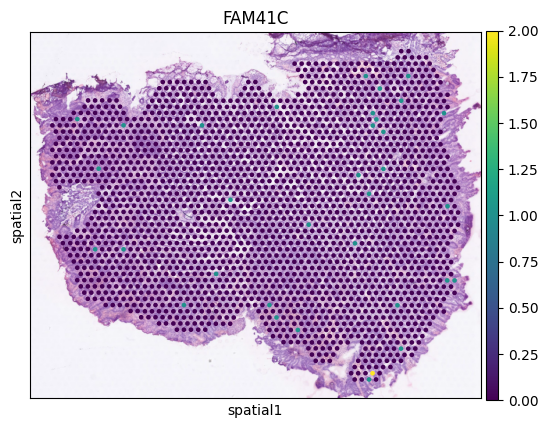

In [22]:
# Plot spatial expression map for a specific gene (example: FAM41C)
if GENE is not None:
    save_dir = "figures/show/data_overview/"
    os.makedirs(save_dir, exist_ok=True)
    sc.pl.spatial(adata, color=GENE, save=os.path.join("/data_overview/", GENE + ".st_plot.png"))


In [23]:
# Create an interactive dropdown for visualizing gene expression spatially
gene_dropdown = widgets.Dropdown(
    options=list(adata.var_names),   # all available gene names
    value=adata.var_names[0],        # default selected gene
    description='Gene:',
    layout=widgets.Layout(width='400px')
)

# Function to plot spatial expression of the selected gene
def plot_gene(gene):
    plt.close('all')
    sc.pl.spatial(adata, color=gene, spot_size=1, show=True)

# Link dropdown selection with plotting function
widgets.interact(plot_gene, gene=gene_dropdown)


interactive(children=(Dropdown(description='Gene:', layout=Layout(width='400px'), options=('MIR1302-2HG', 'FAM…

<function __main__.plot_gene(gene)>